In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Load dataset
df = pd.read_csv('Blocks with feature.csv')

# Select features
features = ['blocks_per_pool_last_10','blocks_per_pool_per_day' ,
            'is_consecutive_block', 'is_unique_miner_last_100']
X = df[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set contamination level (proportion of expected outliers)
contamination_rate = 0.3

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=contamination_rate, random_state=42)
iso_forest.fit(X_scaled)

# Predict outliers (-1 = outlier, 1 = inlier)
df['outlier'] = iso_forest.predict(X_scaled)

# Count and print number of outliers
num_outliers = (df['outlier'] == -1).sum()
print(f"Number of outliers detected: {num_outliers}")


Number of outliers detected: 16620


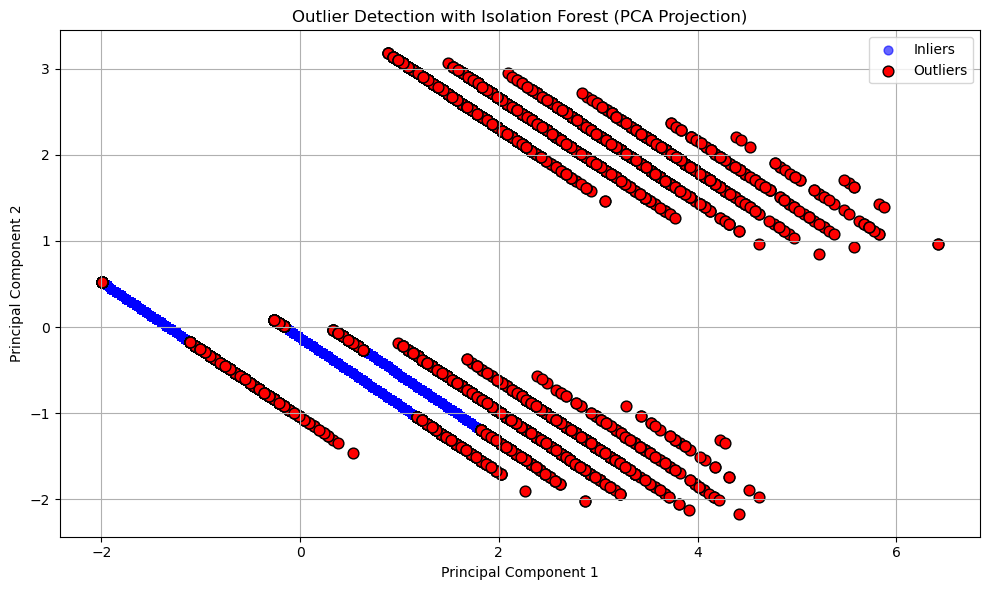

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[df['outlier'] == 1, 0], X_pca[df['outlier'] == 1, 1], 
            c='blue', label='Inliers', s=40, alpha=0.6)
plt.scatter(X_pca[df['outlier'] == -1, 0], X_pca[df['outlier'] == -1, 1], 
            c='red', label='Outliers', s=60, edgecolors='k')
plt.title('Outlier Detection with Isolation Forest (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Optimal clusters: 9 (Silhouette Score: 0.571)


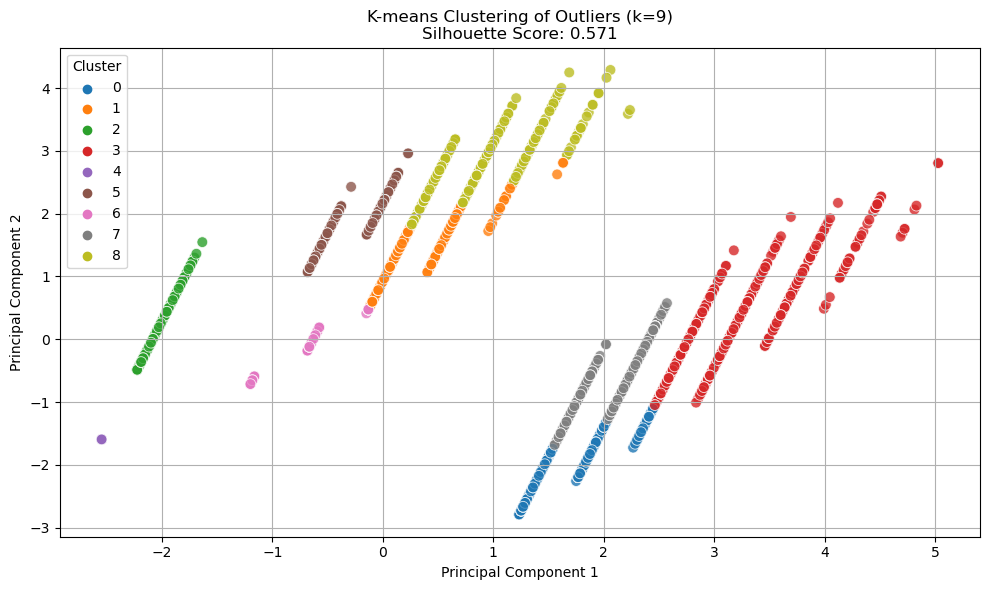


Number of points in each cluster:
Cluster 0: 2045 points
Cluster 1: 1961 points
Cluster 2: 3638 points
Cluster 3: 1663 points
Cluster 4: 1341 points
Cluster 5: 1584 points
Cluster 6: 1179 points
Cluster 7: 1681 points
Cluster 8: 1528 points


In [15]:
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree  # For visualization
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,  # Classification metrics
    confusion_matrix, classification_report,
    mean_squared_error, r2_score  # Regression metrics
)
# Separate outliers
df_outliers = df[df['outlier'] == -1].copy()
X_outliers = scaler.transform(df_outliers[features])

# Cluster outliers with KMeans
best_k = 2
best_score = -1
for k in range(9, 10):  # You can increase upper range if more clustering needed
    kmeans = KMeans(n_clusters=k, random_state=30 ,n_init='auto').fit(X_outliers)
    score = silhouette_score(X_outliers, kmeans.labels_)
    if score > best_score:
        best_score = score
        best_k = k

# Final clustering
kmeans = KMeans(n_clusters=best_k, random_state=30 , n_init='auto')
df_outliers['cluster'] = kmeans.fit_predict(X_outliers)

print(f"Optimal clusters: {best_k} (Silhouette Score: {best_score:.3f})")

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca_outliers = pca.fit_transform(X_outliers)
df_outliers['PC1'] = X_pca_outliers[:, 0]
df_outliers['PC2'] = X_pca_outliers[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_outliers,
    x='PC1',
    y='PC2',
    hue='cluster',
    palette='tab10',
    alpha=0.8,
    s=60
)
plt.title(f'K-means Clustering of Outliers (k={best_k})\nSilhouette Score: {best_score:.3f}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print number of points in each cluster
cluster_counts = df_outliers['cluster'].value_counts().sort_index()
print("\nNumber of points in each cluster:")
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} points")


--- Training Metrics ---
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     36372
           1       0.97      1.00      0.98      8370

    accuracy                           0.99     44742
   macro avg       0.98      1.00      0.99     44742
weighted avg       0.99      0.99      0.99     44742

Confusion Matrix (Train):
[[36111   261]
 [    0  8370]]
Accuracy Score (Train): 0.9942

--- Testing Metrics ---
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      9094
           1       0.98      1.00      0.99      2092

    accuracy                           1.00     11186
   macro avg       0.99      1.00      0.99     11186
weighted avg       1.00      1.00      1.00     11186

Confusion Matrix (Test):
[[9041   53]
 [   0 2092]]
Accuracy Score (Test): 0.9953


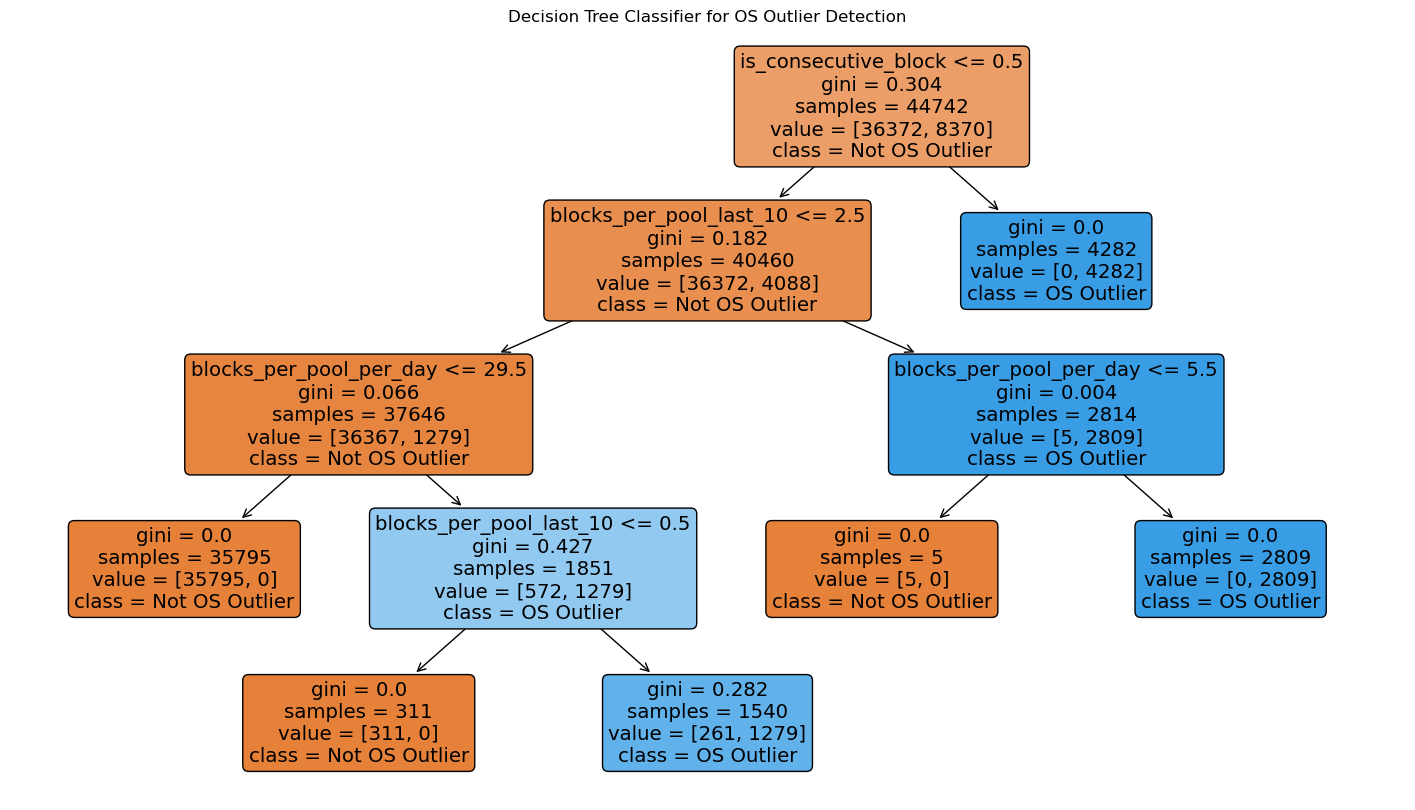

Decision Tree Structure (Rules):
|--- is_consecutive_block <= 0.50
|   |--- blocks_per_pool_last_10 <= 2.50
|   |   |--- blocks_per_pool_per_day <= 29.50
|   |   |   |--- class: 0
|   |   |--- blocks_per_pool_per_day >  29.50
|   |   |   |--- blocks_per_pool_last_10 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- blocks_per_pool_last_10 >  0.50
|   |   |   |   |--- class: 1
|   |--- blocks_per_pool_last_10 >  2.50
|   |   |--- blocks_per_pool_per_day <= 5.50
|   |   |   |--- class: 0
|   |   |--- blocks_per_pool_per_day >  5.50
|   |   |   |--- class: 1
|--- is_consecutive_block >  0.50
|   |--- class: 1



In [17]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Label os_outlier
df['os_outlier'] = 0
outlier_indices = df_outliers[df_outliers['cluster'].isin([0,1,3,5,7,8])].index
df.loc[outlier_indices, 'os_outlier'] = 1



# Train-test split
X = df[features]
y = df['os_outlier']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train decision tree
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

# Predict on training set
y_train_pred = clf.predict(X_train)
print("\n--- Training Metrics ---")
print("Classification Report (Train):")
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix (Train):")
print(confusion_matrix(y_train, y_train_pred))
print(f"Accuracy Score (Train): {accuracy_score(y_train, y_train_pred):.4f}")

# Predict on testing set
y_test_pred = clf.predict(X_test)
print("\n--- Testing Metrics ---")
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))
print(f"Accuracy Score (Test): {accuracy_score(y_test, y_test_pred):.4f}")

# Visualize decision tree
plt.figure(figsize=(18, 10))
plot_tree(clf, 
          feature_names=features, 
          class_names=['Not OS Outlier', 'OS Outlier'],
          filled=True,
          rounded=True)
plt.title("Decision Tree Classifier for OS Outlier Detection")
plt.show()




from sklearn.tree import export_text

# Print readable tree structure with feature names
tree_rules = export_text(clf, feature_names=features)
print("Decision Tree Structure (Rules):")
print(tree_rules)



In [19]:
from joblib import dump

# حفظ النموذج في ملف
dump(clf, 'decision_tree_model.joblib') 

# لاحقاً يمكنك تحميله بهذه الطريقة:
# from joblib import load
# clf_loaded = load('decision_tree_model.joblib')

['decision_tree_model.joblib']

## Rules for 30% threshold

# Rule 1: Conditions:

is_consecutive_block ≤ 0.50

blocks_per_pool_per_day ≤ 18.50

blocks_per_pool_last_10 ≤ 2.50 Outcome: Class = 0

# Rule 2: Conditions:

is_consecutive_block ≤ 0.50

blocks_per_pool_per_day ≤ 18.50

blocks_per_pool_last_10 > 2.50

blocks_per_pool_per_day ≤ 11.50 Outcome: Class = 0

# Rule 3: Conditions:

is_consecutive_block ≤ 0.50

blocks_per_pool_per_day ≤ 18.50

blocks_per_pool_last_10 > 2.50

blocks_per_pool_per_day > 11.50 Outcome: Class = 1

# Rule 4: Conditions:

is_consecutive_block ≤ 0.50

blocks_per_pool_per_day > 18.50

is_unique_miner_last_100 ≤ 0.50

blocks_per_pool_per_day ≤ 30.50 Outcome: Class = 0

# Rule 5: Conditions:

is_consecutive_block ≤ 0.50

blocks_per_pool_per_day > 18.50

is_unique_miner_last_100 ≤ 0.50

blocks_per_pool_per_day > 30.50 Outcome: Class = 1

# Rule 6: Conditions:

is_consecutive_block ≤ 0.50

blocks_per_pool_per_day > 18.50

is_unique_miner_last_100 > 0.50 Outcome: Class = 1

# Rule 7: Conditions:

is_consecutive_block > 0.50 Outcome: Class = 1


# Explanation of Tree 1:

## Root Check: If is_consecutive_block > 0.50, always return 1.

## First Branch (is_consecutive_block <= 0.50):

If blocks_per_pool_per_day is at most 30.50, then:

If blocks_per_pool_last_10 <= 3.50, return 0.

Otherwise, return 1.

## If blocks_per_pool_per_day is greater than 30.50, then:

If it is ≤ 33.50 and blocks_per_pool_last_10 <= 2.50, return 0.

In all other cases in this branch (either blocks_per_pool_last_10 > 2.50 or blocks_per_pool_per_day > 33.50), return 1.

In [426]:
# Training Metrics
print("\n--- Training Metrics ---")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

# Testing Metrics
print("\n--- Testing Metrics ---")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Classification Report:")
print(classification_report(y_test, y_test_pred))



--- Training Metrics ---
Accuracy: 0.9710
Confusion Matrix:
[[34747   209]
 [ 1089  8697]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     34956
           1       0.98      0.89      0.93      9786

    accuracy                           0.97     44742
   macro avg       0.97      0.94      0.96     44742
weighted avg       0.97      0.97      0.97     44742


--- Testing Metrics ---
Accuracy: 0.9715
Confusion Matrix:
[[8689   50]
 [ 269 2178]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8739
           1       0.98      0.89      0.93      2447

    accuracy                           0.97     11186
   macro avg       0.97      0.94      0.96     11186
weighted avg       0.97      0.97      0.97     11186



In [435]:
# Print feature importances
import pandas as pd

feature_importance = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
print("\n--- Feature Importances ---")
print(feature_importance)



--- Feature Importances ---
is_consecutive_block        0.435780
blocks_per_pool_per_day     0.379421
blocks_per_pool_last_10     0.170854
is_unique_miner_last_100    0.013945
dtype: float64


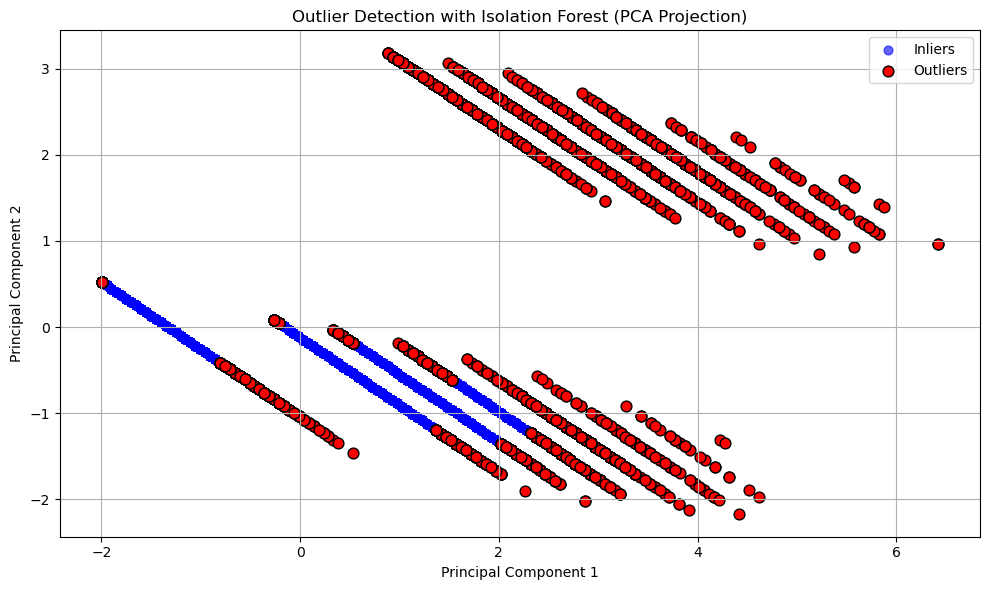

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[df['outlier'] == 1, 0], X_pca[df['outlier'] == 1, 1], 
            c='blue', label='Inliers', s=40, alpha=0.6)
plt.scatter(X_pca[df['outlier'] == -1, 0], X_pca[df['outlier'] == -1, 1], 
            c='red', label='Outliers', s=60, edgecolors='k')
plt.title('Outlier Detection with Isolation Forest (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Optimal clusters: 4 (Silhouette Score: 0.586)


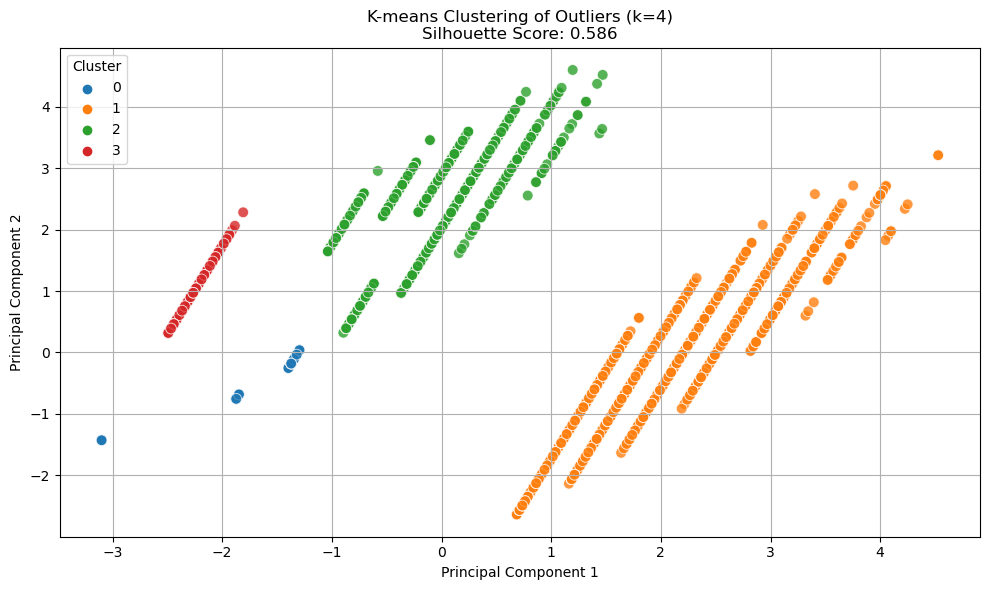


Number of points in each cluster:
Cluster 0: 1914 points
Cluster 1: 5389 points
Cluster 2: 2458 points
Cluster 3: 1421 points

--- Training Metrics ---
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     37328
           1       0.98      0.82      0.89      7414

    accuracy                           0.97     44742
   macro avg       0.97      0.91      0.94     44742
weighted avg       0.97      0.97      0.97     44742

Confusion Matrix (Train):
[[37209   119]
 [ 1342  6072]]
Accuracy Score (Train): 0.9673

--- Testing Metrics ---
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9332
           1       0.98      0.81      0.89      1854

    accuracy                           0.97     11186
   macro avg       0.97      0.90      0.93     11186
weighted avg       0.97      0.97      0.96     11186

Confusion Matrix (T

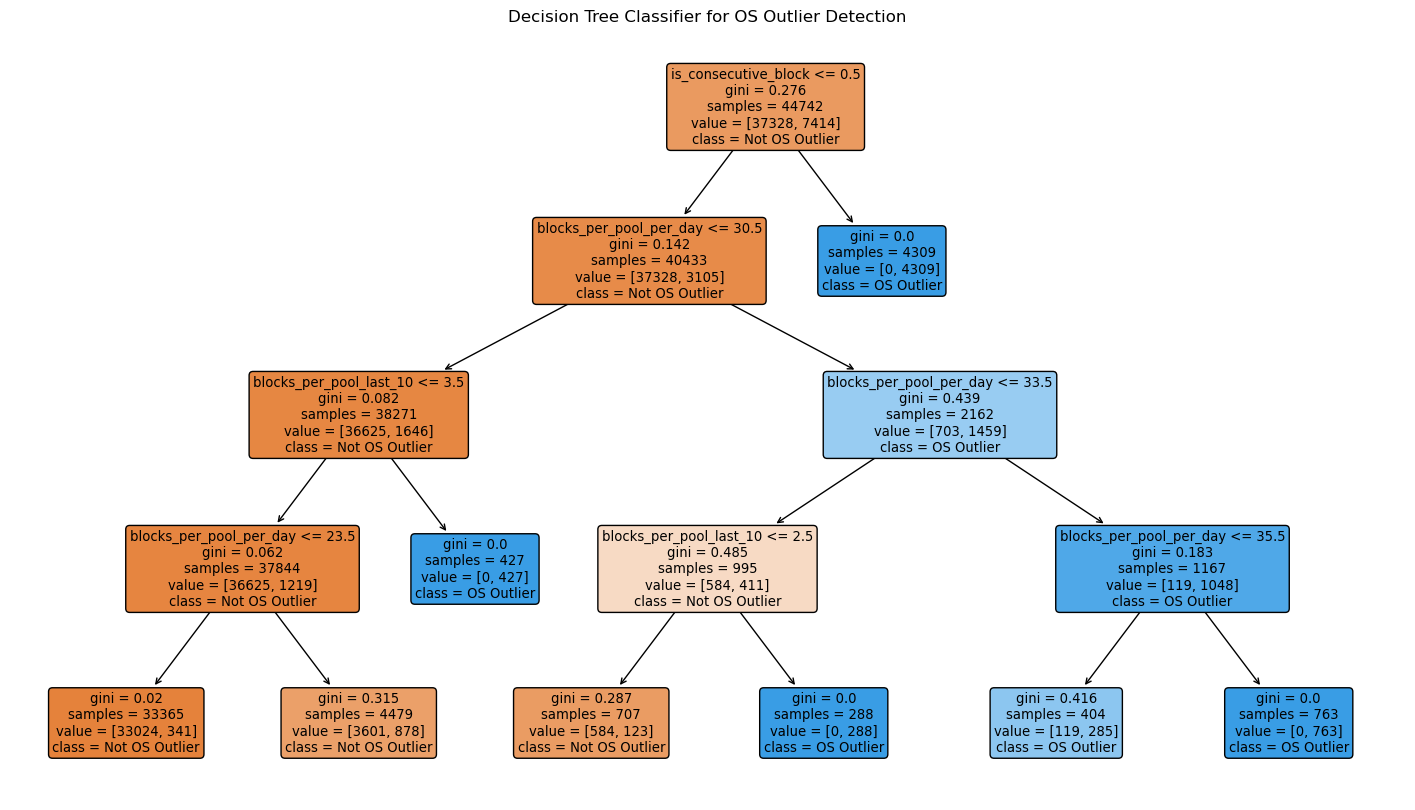

Decision Tree Structure (Rules):
|--- is_consecutive_block <= 0.50
|   |--- blocks_per_pool_per_day <= 30.50
|   |   |--- blocks_per_pool_last_10 <= 3.50
|   |   |   |--- blocks_per_pool_per_day <= 23.50
|   |   |   |   |--- class: 0
|   |   |   |--- blocks_per_pool_per_day >  23.50
|   |   |   |   |--- class: 0
|   |   |--- blocks_per_pool_last_10 >  3.50
|   |   |   |--- class: 1
|   |--- blocks_per_pool_per_day >  30.50
|   |   |--- blocks_per_pool_per_day <= 33.50
|   |   |   |--- blocks_per_pool_last_10 <= 2.50
|   |   |   |   |--- class: 0
|   |   |   |--- blocks_per_pool_last_10 >  2.50
|   |   |   |   |--- class: 1
|   |   |--- blocks_per_pool_per_day >  33.50
|   |   |   |--- blocks_per_pool_per_day <= 35.50
|   |   |   |   |--- class: 1
|   |   |   |--- blocks_per_pool_per_day >  35.50
|   |   |   |   |--- class: 1
|--- is_consecutive_block >  0.50
|   |--- class: 1



In [12]:
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree  # For visualization
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,  # Classification metrics
    confusion_matrix, classification_report,
    mean_squared_error, r2_score  # Regression metrics
)

# Separate outliers
df_outliers = df[df['outlier'] == -1].copy()
X_outliers = scaler.transform(df_outliers[features])

# Cluster outliers with KMeans
best_k = 2
best_score = -1
for k in range(2, 7):  # You can increase upper range if more clustering needed
    kmeans = KMeans(n_clusters=k, random_state=30 ,n_init='auto').fit(X_outliers)
    score = silhouette_score(X_outliers, kmeans.labels_)
    if score > best_score:
        best_score = score
        best_k = k

# Final clustering
kmeans = KMeans(n_clusters=best_k, random_state=30 , n_init='auto')
df_outliers['cluster'] = kmeans.fit_predict(X_outliers)

print(f"Optimal clusters: {best_k} (Silhouette Score: {best_score:.3f})")

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca_outliers = pca.fit_transform(X_outliers)
df_outliers['PC1'] = X_pca_outliers[:, 0]
df_outliers['PC2'] = X_pca_outliers[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_outliers,
    x='PC1',
    y='PC2',
    hue='cluster',
    palette='tab10',
    alpha=0.8,
    s=60
)
plt.title(f'K-means Clustering of Outliers (k={best_k})\nSilhouette Score: {best_score:.3f}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print number of points in each cluster
cluster_counts = df_outliers['cluster'].value_counts().sort_index()
print("\nNumber of points in each cluster:")
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} points")
    
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Label os_outlier
df['os_outlier'] = 0
outlier_indices = df_outliers[df_outliers['cluster'].isin([1,2,3])].index
df.loc[outlier_indices, 'os_outlier'] = 1



# Train-test split
X = df[features]
y = df['os_outlier']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train decision tree
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

# Predict on training set
y_train_pred = clf.predict(X_train)
print("\n--- Training Metrics ---")
print("Classification Report (Train):")
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix (Train):")
print(confusion_matrix(y_train, y_train_pred))
print(f"Accuracy Score (Train): {accuracy_score(y_train, y_train_pred):.4f}")

# Predict on testing set
y_test_pred = clf.predict(X_test)
print("\n--- Testing Metrics ---")
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))
print(f"Accuracy Score (Test): {accuracy_score(y_test, y_test_pred):.4f}")

# Visualize decision tree
plt.figure(figsize=(18, 10))
plot_tree(clf, 
          feature_names=features, 
          class_names=['Not OS Outlier', 'OS Outlier'],
          filled=True,
          rounded=True)
plt.title("Decision Tree Classifier for OS Outlier Detection")
plt.show()




from sklearn.tree import export_text

# Print readable tree structure with feature names
tree_rules = export_text(clf, feature_names=features)
print("Decision Tree Structure (Rules):")
print(tree_rules)




## Rules based on 20% outlier threshold

# Rule 1: Condition:

is_consecutive_block ≤ 0.50

blocks_per_pool_per_day ≤ 30.50

blocks_per_pool_last_10 ≤ 3.50 Outcome: Class = 0

# Rule 2: Condition:

is_consecutive_block ≤ 0.50

blocks_per_pool_per_day ≤ 30.50

blocks_per_pool_last_10 > 3.50 Outcome: Class = 1

# Rule 3: Condition:

is_consecutive_block ≤ 0.50

blocks_per_pool_per_day > 30.50

blocks_per_pool_per_day ≤ 33.50

blocks_per_pool_last_10 ≤ 2.50 Outcome: Class = 0

Rule 4: Condition:

# is_consecutive_block ≤ 0.50

blocks_per_pool_per_day > 30.50

blocks_per_pool_per_day ≤ 33.50

blocks_per_pool_last_10 > 2.50 Outcome: Class = 1

# Rule 5: Condition:

is_consecutive_block ≤ 0.50

blocks_per_pool_per_day > 33.50 Outcome: Class = 1 (Note: In this branch, regardless of further conditions on blocks_per_pool_per_day, the outcome is always Class = 1.)

# Rule 6: Condition:

is_consecutive_block > 0.50 Outcome: Class = 1

Root Check: If is_consecutive_block > 0.50, return 1.

First Branch (is_consecutive_block <= 0.50):

If blocks_per_pool_per_day is ≤ 18.50:

If blocks_per_pool_last_10 ≤ 2.50, return 0.

Otherwise (if blocks_per_pool_last_10 > 2.50), check if blocks_per_pool_per_day is ≤ 11.50:

If yes, return 0; if not, return 1.

If blocks_per_pool_per_day is > 18.50:

Check is_unique_miner_last_100:

If it is ≤ 0.50:

If blocks_per_pool_per_day is ≤ 30.50 then return 0; else return 1.

If it is > 0.50, return 1.